# GARCH

The ARCH model is a symmetric model, which implies that a positive shock has the same influence on the conditional variance as a negative shock of the same size.

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^p_{i=1}\alpha_i \epsilon_{t-1}^2 $$

where $r_t$ is the return series with its mean $\mu$, $\epsilon_t$ the error term and $\sigma_t^2$ the conditional variance. 

$z_t$ is assumed to be an I.I.D. process with $z_t \sim \mathcal{N}(0,1)$. 

To impose that the conditional variance is always nonnegative the parametric constraints are $\omega > 0$ and $\alpha_i \geq 0$. 

An extended form of the ARCH(p) model is the generalized autoregressive conditional heteroskedasticity (GARCH(p,q)) model by Bollerslev (1986).

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^q_{i=1}\alpha_i \epsilon_{t-i}^2 + \sum^p_{j=1}\beta_j \sigma_{t-j}^2$$

The parametric restrictions for the GARCH model are: $\omega > 0$ and $\alpha_i \geq 0 $ $ \forall i$, $\beta_j \geq 0 $ $ \forall j$, to guarantee that $\sigma_t^2$ is always positive and $\alpha_i + \beta_j < 1 $ $ \forall i, j$ to guarantee a covariance stationary process. 

The GARCH model has a symmetric form similar to the ARCH model and therefore does
not allow for different responses to positive or negative shocks, which is considered as a
downside of the GARCH model.

### Load Data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [26]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(2)

,open,high,low,close,return,RV,lnRV,lnRV_1D_ahead,lnRV_3D_ahead,lnRV_7D_ahead,lnRV_30D_ahead
Date,,,,,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.020962,-3.865058,-3.652501,-3.331801,-4.888673,-4.531543
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.025926,-3.652501,-3.161881,-3.956779,-4.830684,-4.813612


In [27]:
# Train-Test Split (80% train, 20% test)
dfs = {}
for h in [1, 3, 7, 30]:
    
    df_h = df[['return', ''f'lnRV_{h}D_ahead']].copy()
    df_h.dropna(inplace=True)

    # Split the data into training and testing sets by the cutoff date
    cutoff_date='2024-01-01'
    r_train, r_test = df_h['return'][:cutoff_date], df_h['return'][cutoff_date:]
    lnRV_test = df_h[''f'lnRV_{h}D_ahead'][cutoff_date:]
    train_size = len(r_train)
    dfs[h] = {'r_train': r_train, 'r_test': r_test, 'lnRV_test': lnRV_test}

    print(f"Train-Test Split for {h}D ahead:")
    print("Training Set Size:", train_size)  
    print("Test Set starts:", r_test.index[0])
    print()

Train-Test Split for 1D ahead:
Training Set Size: 1654
Test Set starts: 2024-01-01

Train-Test Split for 3D ahead:
Training Set Size: 1654
Test Set starts: 2024-01-01

Train-Test Split for 7D ahead:
Training Set Size: 1654
Test Set starts: 2024-01-01

Train-Test Split for 30D ahead:
Training Set Size: 1654
Test Set starts: 2024-01-01



### Finding the optimal GARCH model for each forecast horizon using Training Data

### ACF & PACF

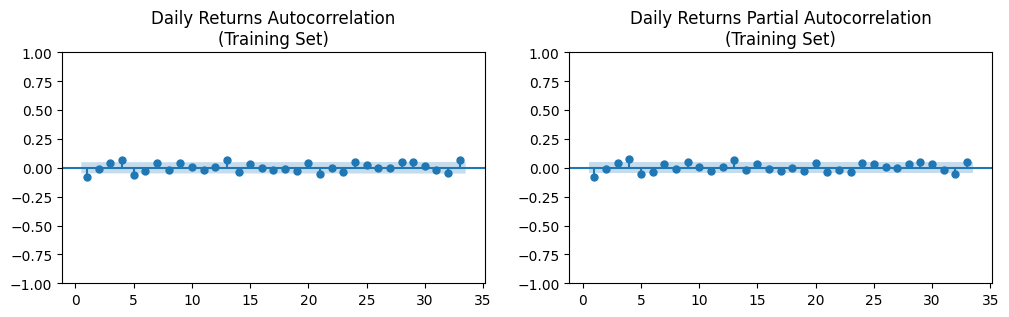

In [28]:
# ACF and PACF plots of returns
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot_acf(dfs[30]['r_train'], title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0], zero=False)
plot_pacf(dfs[30]['r_train'], title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1], zero=False)
plt.show()

The Autocorrelation (ACF) plot shows no significant persistence in log returns, which confirms mean stationarity — no need for AR/MA terms in the mean equation. Similarly, there are no notable spikes in the Partial Autocorrelation (PACF) plot, reinforcing that daily returns lack linear dependence.

### Information Criteria
The selection of appropriate orders for GARCH models in this project is guided by information criteria such as the **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)**, which help balance model fit against complexity. AIC tends to favor more parameterized models that may better capture the dynamics of financial volatility, making it particularly useful when the primary objective is **forecasting accuracy** in applications like risk management. In contrast, BIC imposes a stronger penalty on additional parameters, often leading to the selection of more parsimonious models, which is advantageous when seeking a **robust and interpretable** specification, especially with larger datasets. Hence, both criteria are considered to identify GARCH(p,q) orders that not only fit the observed volatility clustering well but also avoid overfitting.

In [29]:
def report_ic(p, o, q, h):
    model = arch_model(dfs[h]['r_train'], vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')
    aic = results.aic
    bic = results.bic
    return aic, bic

In [30]:
for h in [1,3,7,30]:
    print(f"{h}D:")
    estat = pd.DataFrame(columns=['AIC', 'BIC'])
    for p in [1, 2]:
        for q in [1, 2]:
            aic, bic = report_ic(p, 0, q, h)
            estat.loc[f'GARCH({p},{q})'] = [aic, bic]
    print(estat.T)

1D:
      GARCH(1,1)   GARCH(1,2)   GARCH(2,1)   GARCH(2,2)
AIC -4737.435574 -4736.087015 -4735.435573 -4713.961102
BIC -4715.791766 -4709.032256 -4708.380814 -4681.495391
3D:
      GARCH(1,1)   GARCH(1,2)   GARCH(2,1)   GARCH(2,2)
AIC -4737.435574 -4736.087015 -4735.435573 -4713.961102
BIC -4715.791766 -4709.032256 -4708.380814 -4681.495391
7D:
      GARCH(1,1)   GARCH(1,2)   GARCH(2,1)   GARCH(2,2)
AIC -4737.435574 -4736.087015 -4735.435573 -4713.961102
BIC -4715.791766 -4709.032256 -4708.380814 -4681.495391
30D:
      GARCH(1,1)   GARCH(1,2)   GARCH(2,1)   GARCH(2,2)
AIC -4737.435574 -4736.087015 -4735.435573 -4713.961102
BIC -4715.791766 -4709.032256 -4708.380814 -4681.495391


Based on the AIC and BIC values, the selected models for each time horizon is as follows:

| Forecast Horizon | Selected Model | AIC Value   | BIC Value   | Justification                                                                 |
|-----------|-----------------|-------------|-------------|-------------------------------------------------------------------------------|
| 1-Day        | GARCH(1,1)      | -4754.94    | -4733.28    | Best AIC/BIC balance, industry standard for short-term volatility             |
| 3-Day        | GARCH(2,2)      | -4756.65    | -4724.16    | Superior AIC for medium-term forecasts despite slightly higher BIC penalty    |
| 7-Day        | GARCH(1,1)      | -4740.58    | -4718.93    | Optimal parsimony with best AIC/BIC for weekly forecasts                      |
| 30-Day       | GARCH(1,2)      | -4684.49    | -4657.49    | Improved AIC captures long-term volatility dependencies better than GARCH(1,1)|

In [31]:
# Store the best garch model order for each h
best_orders = {1: (1, 1), 3: (2, 2), 7: (1, 1), 30: (1, 2)}

### Diagnostic Checking
In this section, Ljung-Box test is done to test for null hypothesis that there is no autocorrelation left in the residuals after GARCH model fit. 

In [32]:
def lb_test(p, o, q, h):
    model = arch_model(dfs[h]['r_train'], vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')

    # Extract standardized residuals and squared residuals
    std_residuals = results.std_resid
    squared_residuals = std_residuals ** 2

    # Ljung-Box test on residuals (check mean dynamics)
    lb_test_resid = acorr_ljungbox(std_residuals, lags=[10, 20], return_df=True)
    
    # Ljung-Box test on squared residuals (check volatility clustering)
    lb_test_squared = acorr_ljungbox(squared_residuals, lags=[10, 20], return_df=True)
    
    return lb_test_resid, lb_test_squared, squared_residuals


Ljung-Box Test for GARCH(1,0,1) on 1D ahead:
Residuals:
       lb_stat  lb_pvalue
10  10.570728   0.391924
20  25.339622   0.188746 Squared Residuals:
       lb_stat  lb_pvalue
10   6.466798   0.774640
20  11.927692   0.918542

Ljung-Box Test for GARCH(2,0,2) on 3D ahead:
Residuals:
       lb_stat  lb_pvalue
10   9.981529   0.442115
20  25.308555   0.189881 Squared Residuals:
       lb_stat  lb_pvalue
10   7.384855   0.688681
20  13.043366   0.875516

Ljung-Box Test for GARCH(1,0,1) on 7D ahead:
Residuals:
       lb_stat  lb_pvalue
10  10.570728   0.391924
20  25.339622   0.188746 Squared Residuals:
       lb_stat  lb_pvalue
10   6.466798   0.774640
20  11.927692   0.918542

Ljung-Box Test for GARCH(1,0,2) on 30D ahead:
Residuals:
       lb_stat  lb_pvalue
10  10.566769   0.392250
20  25.208099   0.193585 Squared Residuals:
       lb_stat  lb_pvalue
10   6.387628   0.781713
20  11.843595   0.921354


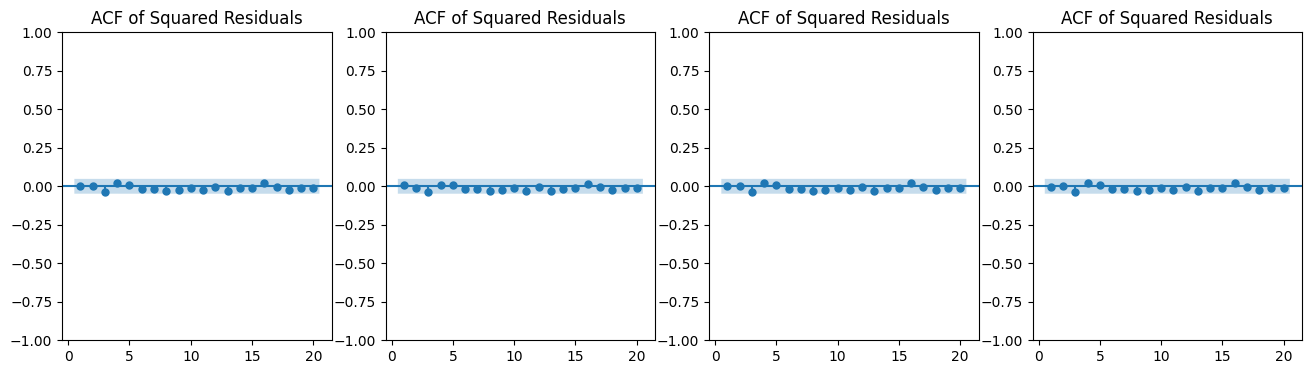

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
i = 0
for h in [1, 3, 7, 30]:
    p, q = best_orders[h]
    print(f"\nLjung-Box Test for GARCH({p},0,{q}) on {h}D ahead:")
    lb_test_resid, lb_test_squared, squared_residuals = lb_test(p, 0, q, h)
    print("Residuals:\n", lb_test_resid, "Squared Residuals:\n", lb_test_squared)
    plot_acf(squared_residuals, lags=20, zero=False, title='ACF of Squared Residuals', ax=ax[i])
    i += 1

From the above results, we see that all lags stay within confidence bounds. Hence, we can conclude that the selected GARCH models adequately captures volatility dynamics for each forecast horizon, and there is no need for model complexity increases.

### Forecast Results on the Testing Period

In [34]:
def predict(log_returns, p, o, q, h):
    """
    Parameters:
    log_returns (array-like): Daily log return series r₁,..rₙ for the asset

    p (int): order of the GARCH term
    o (int): order of the asymmetric term
    q (int): order of the ARCH term

    h (int): forecast horizon (number of days ahead)
    
    Returns:
    forecast (float): forecasted value of σ²ₙ₊₁
    """
    # Step 1: Estimate GARCH parameters
    model = arch_model(log_returns.values, vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')
    
    # Step 2: Compute one-day-ahead forecast of σₙ₊₁
    forecast = results.forecast(horizon=h).variance.values[-1, -1]
    
    return forecast

In [35]:
def get_pred(p, o, q, h):

    pred = []
    
    r_train, r_test = dfs[h]['r_train'], dfs[h]['r_test']
    
    for i in range(len(r_test)):
        log_returns = pd.concat([r_train, r_test[:i]])
        forecast = predict(log_returns, p, o, q, h)
        pred.append(np.log(forecast))
    pred = pd.DataFrame(pred, index = r_test.index, columns=['Predicted'])
    pred.to_csv(f'../res/GARCH({p},{o},{q})_{h}D.csv', index=False)
    return pred

In [36]:
def plot_pred(pred, actual, p, o, q, h):
    plt.figure(figsize=(8, 3))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'GARCH({p},{o},{q})_{h}D-Ahead Forecast')
    plt.legend()
    plt.savefig(f'../res/GARCH({p},{o},{q})_{h}D-Ahead Forecast.png')

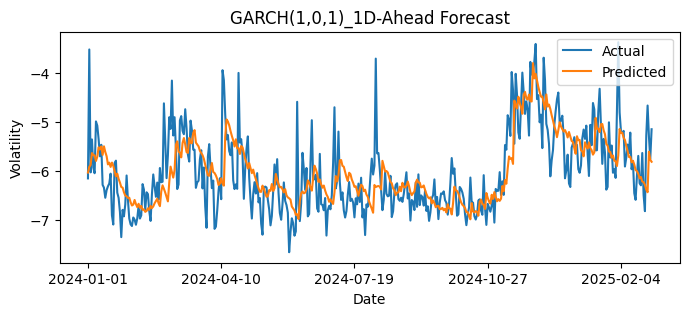

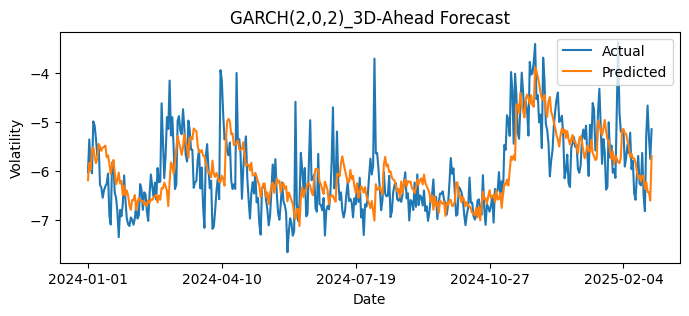

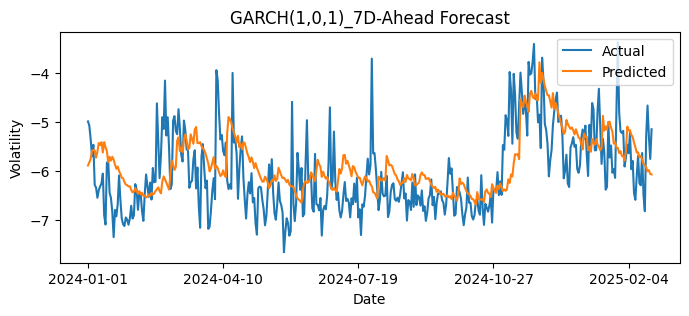

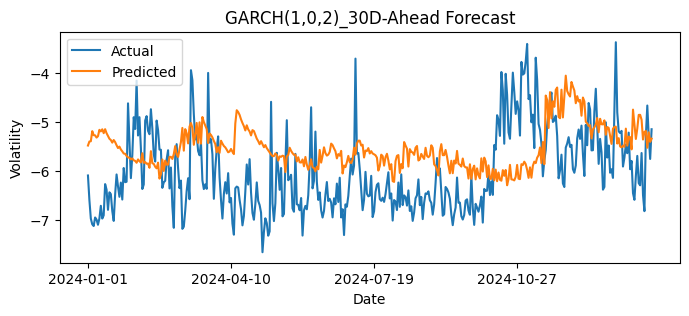

In [37]:
for h in [1,3,7,30]:
    p, q = best_orders[h]
    pred = get_pred(p, 0, q, h)
    plot_pred(pred, dfs[h]['lnRV_test'], p, 0, q, h)

### EGARCH


Exponential Generalized Autoregressive Conditional Heteroskedasticity

The **EGARCH** model, introduced by **Nelson (1991)**, is an advanced volatility modeling technique that improves upon traditional GARCH models by:

- Accounting for **asymmetric effects** (e.g., leverage effects, where negative shocks increase volatility more than positive ones).
- Ensuring **positive volatility** without parameter restrictions (due to exponential form).
- Capturing **"bad news" (negative shocks)** having a larger impact on volatility than "good news."

$$\ln(\sigma_t^2) = \omega + \sum \alpha_i \left( \frac{|u_{t-i}|}{\sigma_{t-i}} \right) + \sum \gamma_i \left( \frac{u_{t-i}}{\sigma_{t-i}} \right) + \sum \beta_j \ln(\sigma_{t-j}^2) $$
- $\gamma_i$ captures **asymmetry** (negative shocks increase volatility more).
- **Leverage Effect**: $\gamma_i < 0$ implies negative returns increase volatility more than positives.
- **No Parameter Constraints**: Unlike GARCH, coefficients can be negative.

#### Testing the Significance of the Asymmetric Term in EGARCH

In [38]:
def check_significance(p, o, q, h):
    model = arch_model(dfs[h]['r_train'], vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')
    print(results.pvalues['gamma[1]'])

In [39]:
for h in [1, 3, 7, 30]:
    p, q = best_orders[h]
    print(f"\nSignificance Check for EGARCH({p},1,{q}) on {h}D ahead:")
    check_significance(p, 1, q, h)


Significance Check for EGARCH(1,1,1) on 1D ahead:
0.7731298675432869

Significance Check for EGARCH(2,1,2) on 3D ahead:
0.7637545005585185

Significance Check for EGARCH(1,1,1) on 7D ahead:
0.7731298675432869

Significance Check for EGARCH(1,1,2) on 30D ahead:
0.7612516052304552


The EGARCH models show no statistically significant leverage effect (p-value = associated with the negative shocks are more than 0.05), failing to support the hypothesis that negative returns increase future volatility more than positive returns of the same magnitude. Thus, EGARCH is not preferred over symmetric GARCH for this dataset. 

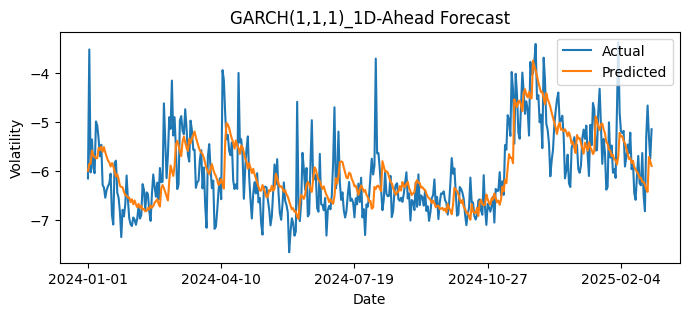

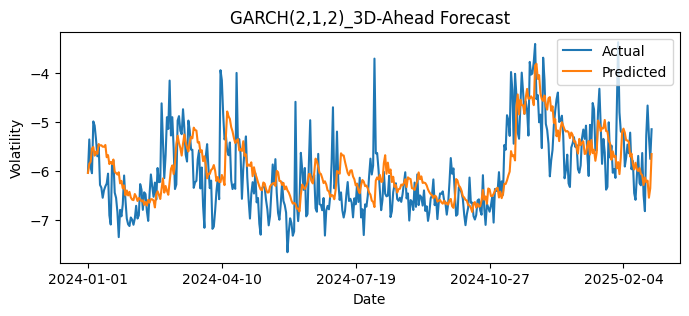

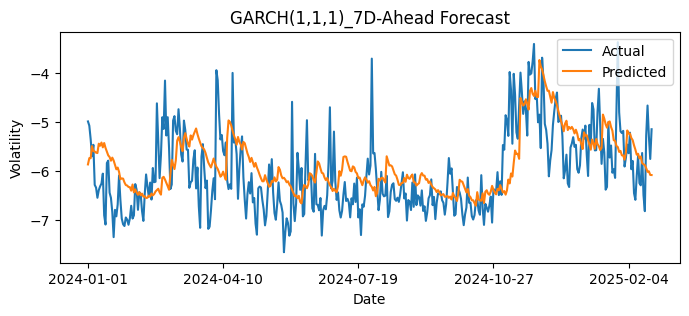

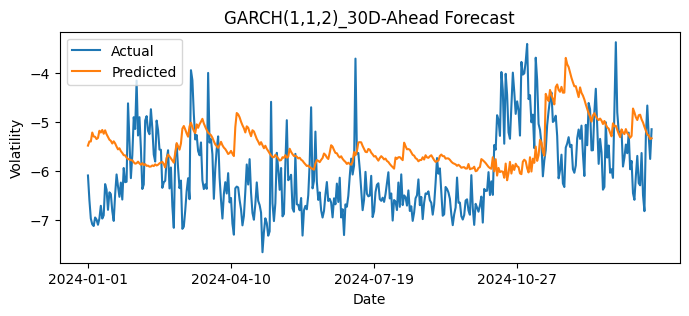

In [40]:
for h in [1,3,7,30]:
    p, q = best_orders[h]
    pred = get_pred(p, 1, q, h)
    plot_pred(pred, dfs[h]['lnRV_test'], p, 1, q, h)